In [70]:
%matplotlib widget
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, plot, process

In [71]:
# Load raw *.fid data
file = Path(
    "../data/20230820-171854-Water-1H-rabi-nutation/20230820-171853-Water-1H-one_of_repeated_90_degree_pulses,length=13.956594323873123us,delay=30us,repetition_time=5s.fid"
)
fid = FID1D.from_file(file)

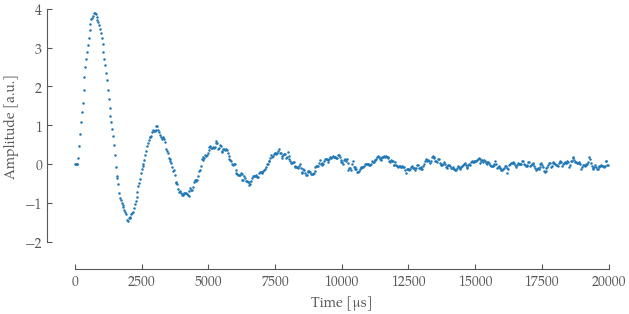

In [72]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [μs]")

plot.format_axes(axes)

fig.savefig("fid_raw.pdf")

In [73]:
# Try to plot simple least squares fit
# Try fitting the envelope
envelope = np.abs(sps.hilbert(fid.data.real))
fit_lorentz = process.fit_exp_decay(fid.us_scale, envelope)
hz_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
    linewidth=2,
)

# Try fitting the absolute directly
fit_abs = process.fit_exp_decay(fid.us_scale, np.abs(fid.data))
axes.plot(
    hz_scale_fine,
    fit_abs["function"](hz_scale_fine),
    linestyle=":",
    linewidth=2,
)

fig.savefig("fid_fit.pdf")
fig

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Phase Shift: -108.63306250000014


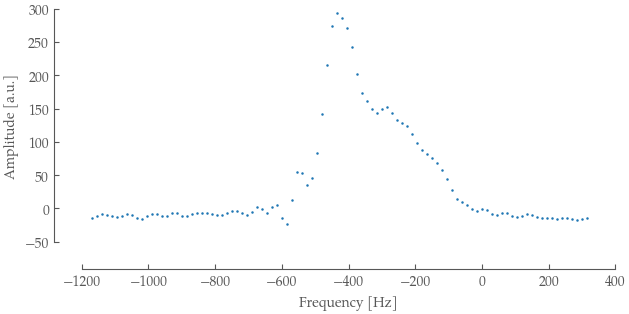

In [74]:
# Fourier Transform
hz_scale, fft_vals,p0 = fid.simple_fft()
# hz_scale, fft_vals = fid.simple_fft(phase_shift_kwargs={"p0": -120})
peak = np.argmax(fft_vals)
peak_hz_scale = hz_scale[peak-50:peak+50]
peak_fft_vals = fft_vals[peak-50:peak+50]
print(f"Phase Shift: {p0}")

# Plot Fourier Transform
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes)

fig.savefig("fft_raw.pdf")

Amplitude: 270.3646329500332
Gamma: 88.13238207600675 Hz
Full Width at Half Maximum: 176.2647641520135 Hz
T2* is thus: 1.805862264730773 ms
Position: -398.04906435909135 Hz


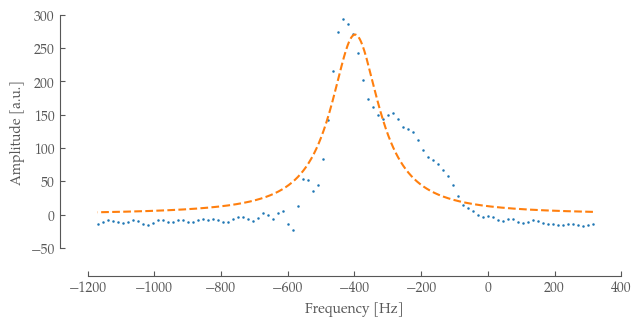

In [75]:
# Try to plot simple least squares fit for a lorentzian peak
fit_lorentz = process.fit_lorentz(peak_hz_scale, peak_fft_vals.real)
hz_scale_fine = np.linspace(peak_hz_scale[0], peak_hz_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
)
print(f"Amplitude: {fit_lorentz['amplitude']}")
print(f"Gamma: {fit_lorentz['gamma']} Hz")
print(f"Full Width at Half Maximum: {fit_lorentz['gamma'] * 2} Hz")
print(f"T2* is thus: {1000/(np.pi * fit_lorentz['gamma']*2)} ms")
print(f"Position: {fit_lorentz['position']} Hz")


fig.savefig("fft_fit.pdf")
fig